In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import math
from matplotlib.colors import LogNorm

import math
from astropy import units
from astropy.wcs import WCS
from scipy.fftpack import fft2, fftshift
from scipy.fft import fft, fftfreq
from scipy.ndimage import map_coordinates
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from skimage.feature import peak_local_max
from astropy.visualization import simple_norm
from scipy.spatial import cKDTree

from matplotlib.patches import Circle
from astropy.visualization.wcsaxes import SphericalCircle
from scipy.signal import resample
from scipy.signal import find_peaks
from matplotlib.patches import Wedge
from reproject import reproject_interp
from photutils.centroids import centroid_2dg
from scipy.ndimage import shift

from turbustat.statistics import PowerSpectrum
import emcee

from scipy.ndimage import gaussian_filter
import webbpsf
from scipy.ndimage import zoom
from scipy.signal import convolve2d

base_dir = "/export/home/extragal/francesco.chititegli/JWST/TESI/"
gallery_dir = '/export/home/extragal/francesco.chititegli/GALLERY/'

# Opening Images

In [2]:
miri_images = ['hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f1000w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f1130w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits']

with fits.open(os.path.join(base_dir, miri_images[3])) as hdul:
    header_F2100W = hdul[1].header
    image_F2100W = hdul[1].data
wcs_F2100W = WCS(header_F2100W)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_F2100W = np.abs(wcs_F2100W.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_F2100W = 1 / pixel_scale_F2100W

print(r'Starting F2100W Unit: ' + str(header_F2100W.get("BUNIT", "Unknown Unit")))
print(r'F2100W mean: ' + str(np.nanmean(image_F2100W)) + ' MJy/sr')
print()

############################################################################################################################
'''
# Ha image HST
with fits.open(os.path.join(base_dir, "hlsp_phangs-hst_hst_acs-wfc_ngc628c_f555w-f658-f814w_v1_ha-img.fits")) as hdul:
    header_Ha = hdul[0].header
    image_Ha = hdul[0].data
wcs_Ha = WCS(header_Ha)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_Ha = np.abs(wcs_Ha.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_Ha = 1 / pixel_scale_Ha

print(r'Starting Ha Unit: ' + str(header_Ha.get("BUNIT", "Unknown Unit")))
print(r'Ha mean before: ' + str(np.nanmean(image_Ha)))
image_Ha = image_Ha * 1e-3
print(r'Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha mean after: ' + str(np.nanmean(image_Ha)))
arcsec2_over_sr = 4.254791e10
#image_Ha = image_Ha * arcsec2_over_sr * 1e-17

image_Ha_surf_bri = image_Ha * (648000 / (np.pi * 1e-3 * distance_ngc628))**2
print(r'Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$')
print(r'Ha mean final: ' + str(np.nanmean(image_Ha)))
print()

############################################################################################################################

# Ha ERROR image HST
with fits.open(os.path.join(base_dir, "hlsp_phangs-hst_hst_acs-wfc_ngc628c_f555w-f658-f814w_v1_ha-err.fits")) as hdul:
    header_Ha_err = hdul[0].header
    image_Ha_err = hdul[0].data
print(r'Starting Ha ERROR Unit: ' + str(header_Ha_err.get("BUNIT", "Unknown Unit")))
print(r'Ha ERROR mean before: ' + str(np.nanmean(image_Ha_err)))
image_Ha_err = image_Ha_err * 1e-3
print(r'Final Ha ERROR Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha ERROR mean after: ' + str(np.nanmean(image_Ha_err)))
print()
'''
############################################################################################################################

# Ha image
with fits.open(os.path.join(base_dir, "NGC0628_MAPS_copt_0.92asec.fits")) as hdul:
    header_Ha = hdul[30].header
    image_Ha = hdul[30].data
wcs_Ha = WCS(header_Ha)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_Ha = np.abs(wcs_Ha.wcs.cd[1][1]) * 3600
arcsecond_length_in_pixels_Ha = 1 / pixel_scale_Ha

print(r'Starting Ha Unit: ' + str(header_Ha.get("BUNIT", "Unknown Unit")))
image_Ha = image_Ha * 1e-3 / (pixel_scale_Ha ** 2)
print(r'Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha)))
arcsec2_over_sr = 4.254791e10
#image_Ha = image_Ha * arcsec2_over_sr * 1e-17
image_Ha_surf_bri = image_Ha * (648000 / (np.pi * 1e-3 * distance_ngc628))**2
print(r'Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha)))
print()

with fits.open(os.path.join(base_dir, "NGC0628_MAPS_copt_0.92asec.fits")) as hdul:
    header_Ha_err = hdul[31].header
    image_Ha_err = hdul[31].data
wcs_Ha_err = WCS(header_Ha_err)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_Ha_err = np.abs(wcs_Ha_err.wcs.cd[1][1]) * 3600
arcsecond_length_in_pixels_Ha_err = 1 / pixel_scale_Ha_err

print(r'Starting Ha Unit: ' + str(header_Ha_err.get("BUNIT", "Unknown Unit")))
image_Ha_err = image_Ha_err * 1e-3 / (pixel_scale_Ha_err ** 2)
print(r'Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha_err)))
arcsec2_over_sr = 4.254791e10
#image_Ha_err = image_Ha_err * arcsec2_over_sr * 1e-17
image_Ha_surf_bri_err = image_Ha_err * (648000 / (np.pi * 1e-3 * distance_ngc628))**2
print(r'Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha_err)))
print()

############################################################################################################################

# Open Mask
with fits.open(os.path.join(base_dir, "NGC0628_nebulae_mask_V2.fits")) as hdul:
    header_Ha_err = hdul[0].header
    mask_Ha_err = hdul[0].data
wcs_Ha_err = WCS(header_Ha_err)
mask_sel = mask_Ha_err == -1
image_Ha = np.where(mask_sel, image_Ha, np.nan)
image_Ha_err = np.where(mask_sel, image_Ha_err, np.nan)

############################################################################################################################

# Align WCS
reference_wcs = wcs_F2100W
reference_shape = image_F2100W.shape

image_Ha_reprojected, footprint_Ha = reproject_interp((image_Ha, wcs_Ha), output_projection=reference_wcs, shape_out=reference_shape)
image_Ha_err_reprojected, footprint_Ha_err = reproject_interp((image_Ha_err, wcs_Ha), output_projection=reference_wcs, shape_out=reference_shape)
print('New image shapes')
print('image_F2100W: ' + str(image_F2100W.shape))
print('image_Ha: ' + str(image_Ha_reprojected.shape))
print('image_Ha_err: ' + str(image_Ha_err_reprojected.shape))

combined_nan_mask = (np.isnan(image_F2100W) | np.isnan(image_Ha_reprojected) | (image_F2100W == 0))

image_F2100W_new = image_F2100W.copy()
image_Ha_new = image_Ha_reprojected.copy()
image_Ha_err_new = image_Ha_err_reprojected.copy()

image_F2100W_new[combined_nan_mask] = np.nan
image_Ha_new[combined_nan_mask] = np.nan
image_Ha_err_new[combined_nan_mask] = np.nan

Starting F2100W Unit: MJy/sr
F2100W mean: 0.66592854 MJy/sr

Starting Ha Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$
Ha mean: 15.73964899030222
Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$
Ha mean: 15.73964899030222

Starting Ha Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$
Ha mean: 0.19371360344383512
Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$
Ha mean: 0.19371360344383512

New image shapes
image_F2100W: (2600, 1891)
image_Ha: (2600, 1891)
image_Ha_err: (2600, 1891)


3.5103902276026344e+38


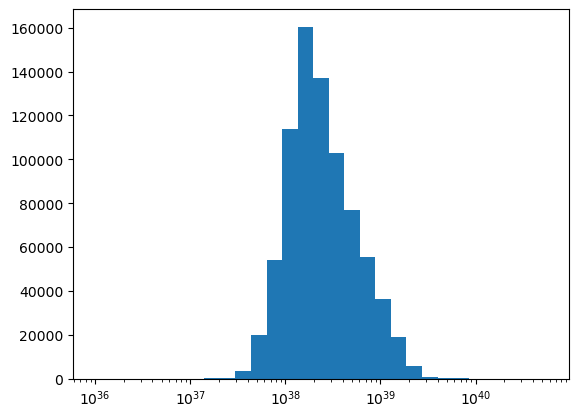

In [15]:
D = 9 * u.Mpc
D_cm = D.to(u.cm).value
image_Ha_L_arcsec2 = image_Ha * 1e-17 * 4 * np.pi * D_cm**2
kpc_per_arcsec = (D.to(u.kpc) * (1 * u.arcsec).to(u.radian)).value
area_kpc2_per_arcsec2 = kpc_per_arcsec**2
image_Ha_L_kpc2 = image_Ha_L_arcsec2 / area_kpc2_per_arcsec2

print(np.nanmean(image_Ha_L_kpc2))

data = image_Ha_L_kpc2[~np.isnan(image_Ha_L_kpc2)]
data = data[data > 0]
bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 30)
plt.hist(data, bins=bins)
plt.xscale('log')
plt.show()

# Visualizing

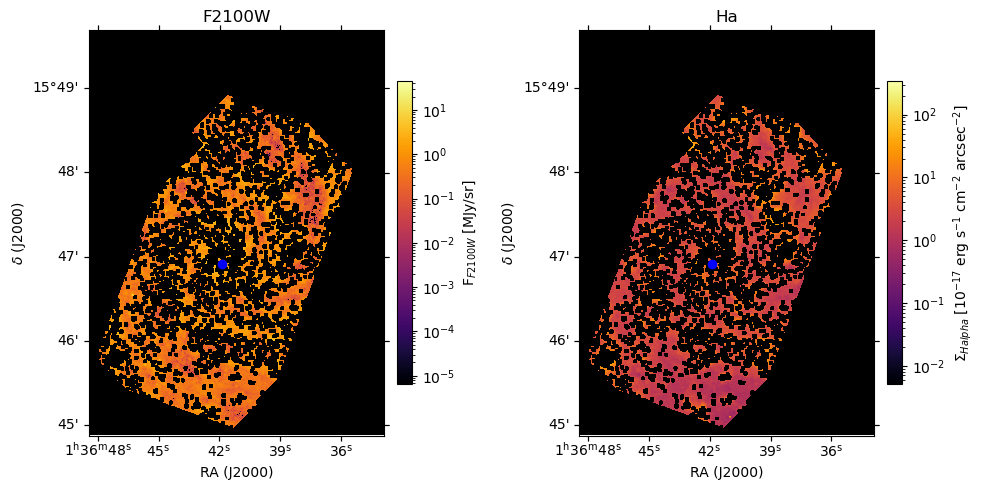

In [3]:
point = [1100,850]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': reference_wcs}, dpi=100)
images = [image_F2100W_new, image_Ha_new]
titles = ['F2100W', 'Ha']
clabels = ['F$_{F2100W}$ [MJy/sr]', r'$\Sigma$$_{Halpha}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]']

for ax, data, title, clabel in zip(axes, images, titles, clabels):
    cmap = plt.cm.inferno.copy()
    cmap.set_bad(color='black')
    
    im = ax.imshow(data, cmap=cmap, origin='lower', norm=LogNorm())
    ax.set_title(title)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(clabel)

    ax.scatter(point[1], point[0],color='blue')

plt.tight_layout()
plt.savefig(f"{gallery_dir}PHANGS_NGC628.jpeg", format='jpeg', dpi=100)
plt.show()

# Scanning Halpha

/tmp/ipykernel_1508133/45282380.py:40: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(masked_image)
/tmp/ipykernel_1508133/45282380.py:41: RuntimeWarning: Mean of empty slice
  error_val = np.nanmean(masked_error)


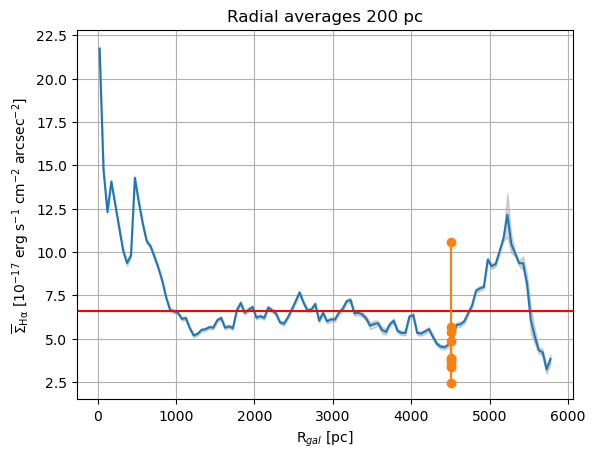

In [19]:
point = [1100, 850]
Ha_TIGRESS = [2.6007, 6.5250, 5.0375, 5.8297, 2.8649, 4.0945, 1.2508, 4.003, 2.290, 10.80]
Ha_TIGRESS = 1e17 * np.array([3.3381700857502055e-17,
5.366844184311836e-17,
3.865932198220236e-17,
3.6919422173801366e-17,
2.45811717291533e-17,
3.794472493942157e-17,
5.6465019758058e-17,
3.495768121136397e-17,
1.056688999903353e-16,
4.8446275355991716e-17])
radii_TIGRESS = [4500] * 10

distance_ngc628 = 9.84e6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_pc = np.abs(reference_wcs.wcs.cdelt[0]) * 3600 * arcsecond_to_pc
thickness_pc = 50
thickness_pix = thickness_pc / pixel_scale_pc

ny, nx = image_Ha_new.shape
Y, X = np.indices((ny, nx))
r = np.sqrt((X - point[1])**2 + (Y - point[0])**2)

r_pc = r * pixel_scale_pc
r_max_pc = r_pc.max()
n_bins = int(r_max_pc // thickness_pc)

scans = []
radii_pc = []
means_Ha = []
errors_Ha = []

for i in range(n_bins):
    r_in = i * thickness_pc
    r_out = (i + 1) * thickness_pc
    mask = (r_pc >= r_in) & (r_pc < r_out)
    masked_image = np.where(mask, image_Ha_new, np.nan)
    masked_error = np.where(mask, image_Ha_err_new, np.nan)
    mean_val = np.nanmean(masked_image)
    error_val = np.nanmean(masked_error)
    scans.append(masked_image)
    
    radii_pc.append((r_in + r_out) / 2)
    means_Ha.append(mean_val)
    errors_Ha.append(error_val)

radii_pc = np.array(radii_pc)
means_Ha = np.array(means_Ha)
errors_Ha = np.array(errors_Ha)

#plt.imshow(scans[5], origin='lower', norm=LogNorm())
#plt.show()

plt.plot(radii_pc, means_Ha)
plt.fill_between(radii_pc, means_Ha - errors_Ha, means_Ha + errors_Ha, alpha=0.3, color='gray')
plt.axhline(y=np.nanmean(image_Ha_new), color='red')
plt.plot(radii_TIGRESS, Ha_TIGRESS, marker='o')
plt.xlabel(r'R$_{gal}$ [pc]')
plt.ylabel(r'$\overline{\Sigma}_{\mathrm{H\alpha}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]')
plt.title('Radial averages 200 pc')
plt.grid()
plt.show()


# Leroy 2023

In [22]:
reference_pixscale_arcsec = np.abs(reference_wcs.wcs.cdelt[0]) * 3600
resam_pixscale_arcsec = 1.7
scale_factor = reference_pixscale_arcsec / resam_pixscale_arcsec
print('From a pixelscale of ' + str(reference_pixscale_arcsec) + ' to ' + str(resam_pixscale_arcsec))
print('Reample factor: ' + str(scale_factor))

reference_shape = (image_F2100W_new.shape[0], image_F2100W_new.shape[1])
resam_shape = (int(reference_shape[0] * scale_factor), int(reference_shape[1] * scale_factor))
print('From ' + str(reference_shape) + ' to ' + str(resam_shape))
print()

resam_wcs = reference_wcs.deepcopy()
resam_wcs.wcs.cdelt = np.array([-resam_pixscale_arcsec/3600 if resam_wcs.wcs.cdelt[0] < 0 else resam_pixscale_arcsec/3600, resam_pixscale_arcsec/3600 if resam_wcs.wcs.cdelt[1] > 0 else -resam_pixscale_arcsec/3600])
image_F2100W_resam, footprint = reproject_interp((image_F2100W_new, reference_wcs), resam_wcs)
image_Ha_resam, footprint = reproject_interp((image_Ha_new * arcsec2_over_sr * 1e-17, reference_wcs), resam_wcs)

print('Means after resampling')
print('IR: ' + str(np.nanmean(image_F2100W_resam)))
print('Ha: ' + str(np.nanmean(image_Ha_resam)))

From a pixelscale of 0.11092585445710201 to 1.7
Reample factor: 0.06525050262182472
From (2600, 1891) to (169, 123)

Means after resampling
IR: 0.8581228334805907
Ha: 2.7106189680751552e-06


2.7106189680751552e-06


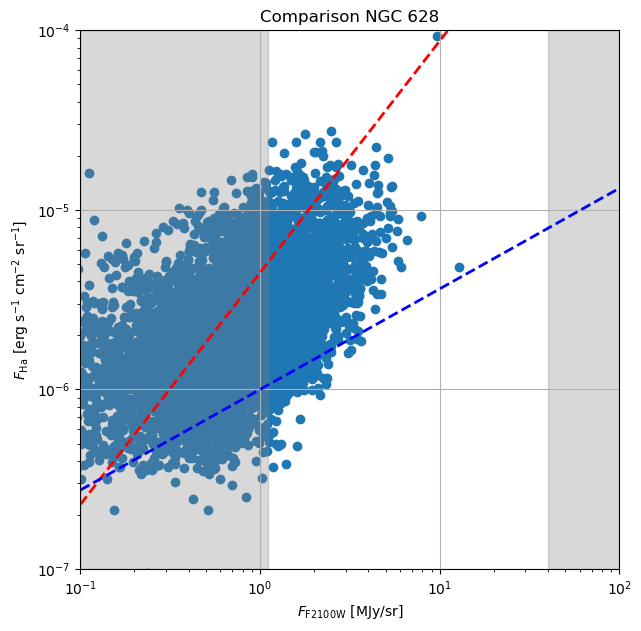

In [26]:
print(np.nanmean(np.nanmean(image_Ha_resam)))

fig, ax = plt.subplots(figsize=(9, 7))

cf = ax.scatter(image_F2100W_resam, image_Ha_resam)

ax.set_xlabel(r'$F_{\mathrm{F2100W}}$ [MJy/sr]')
ax.set_ylabel(r'$F_{\mathrm{Ha}}$ [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'Comparison NGC 628')
ax.grid(True)

ax.axvspan(1e-1, 1.1e0, color='gray', alpha=0.3)
ax.axvspan(10**1.6, 1e3, color='gray', alpha=0.3)

ax.set_xlim(1e-1, 1e2)
ax.set_ylim(1e-7, 1e-4)

x_line = np.linspace(1e-1, 1e3, 100)
y_line = 1.29 * np.log10(x_line) - 5.35
y_line2= 0.56 * np.log10(x_line) - 6
ax.plot(x_line, 10**y_line, 'r--', lw=2)
ax.plot(x_line, 10**y_line2, 'b--', lw=2)

ax.set_aspect('equal')
plt.show()